# DATA WRANGLING
# Armed Conflict and Climate Change

## 0. Introduction
This notebook contains the code to perform the first round of data wrangling on the two datasets used in my first independent Capstone project for the Springboard Data Science Career Track. 

### 0.1 Data Sources
The two datasets used in this analysis are

1. Global Historical Climate Network Daily
- A dataset containing daily climate measurements from 115000+ weather stations around the world, maintained by US National Centers for Environmental Information. This dataset was accessed on October 20, 2020. For more information, visit [url](https://www.ncdc.noaa.gov/ghcn-daily-description).

2. Uppsala Conflict Data Program's Georeferenced Event Database
- A dataset containing information on 225000+ conflict incidents around the world, maintained by the Uppsala Conflict Data Program. This dataset was access on October 20, 2020. For more information, visit [url](https://ucdp.uu.se/downloads/index.html#ged_global).

### 0.2 Research Questions
The overarching, motivating research question is: **Is climate change leading to increased armed conflict?**

However, establishing a causal relationship is difficult in any case, but especially given the nature of the phenomena of ‘climate change’ and ‘armed conflict’. Both phenomena occur across the globe and are influenced by complex layers of social, economic and political factors. It would be far beyond the scope of this project to include all of these factors in a single analysis.

As such, below are a number of sub-questions which I hope to be able to address:

- Are there observable patterns in the data between locations of armed conflict and climate measures at or in the vicinity of those locations? *e.g. Are areas which consistently experience armed conflict also experiencing increased temperatures, increased flooding, or decreased rainfall?*

- Are there correlations between indicators of conflict severity (number of deaths, duration of conflict) and climate measures? *e.g. Are areas which experience intense conflicts also experiencing higher temperatures and/or lower rainfall? Can we use climate measures to predict conflict intensity?*

### 0.3 Overview

The notebook is divided into 7 sections:

0. Introduction
1. Importing packages
2. Importing the raw data
3. Wrangling UCDP Conflict Data
4. Spatial Join of Conflict and Climate Data
5. Wrangling GHCN Climate Data
6. Conclusions

### 0.4 Notes on Data Collection and Related Notebooks
- The actual weather data of the GHCN dataset was extracted from the original tar-archive in a separate notebook, entitled '01 Data Collection' and available in the same Github directory as this notebook. The Data Collection notebook was used to extract the relevant data and store it locally as .csv files. This Data Wrangling notebook imports those local .csv files.

- The Profile Reports for the GHCN data were also generated in a separate notebook, entitled '000 Profile Reports...' and available in the same Github directory as this notebook. Individual profile reports were generated per variable because the dataset was too large to hold in memory to generate 1 profile report. NOTE: the profile report outputs have been removed from this notebook due to incompatability with Github; only the textual analysis has been included.

# 1. Importing packages

In [2]:
# Note to Self: use kernel "Python-geoTiledb208" when working on old MacbookPro (OSX 10.11)
import pandas as pd
import tarfile
from pandas_profiling import ProfileReport
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon 
import contextily as ctx
import warnings
import glob
import os
from IPython.core.display import display, HTML

In [3]:
warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)

# 2. Importing Data

## 2.1. Importing Conflict Data (UCDP)

In [4]:
# import csv from local file as df
df_conflict = pd.read_csv('/Users/richard/Desktop/datasets/UCDP/ucdp-ged-v201.csv')

/Users/richard/miniconda3/envs/sklearn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 2.1.1. Inspecting UCDP Data

In [5]:
df_conflict.shape

(225385, 49)

In [6]:
df_conflict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225385 entries, 0 to 225384
Data columns (total 49 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 225385 non-null  int64  
 1   relid              225385 non-null  object 
 2   year               225385 non-null  int64  
 3   active_year        225385 non-null  int64  
 4   code_status        225385 non-null  object 
 5   type_of_violence   225385 non-null  int64  
 6   conflict_dset_id   225385 non-null  int64  
 7   conflict_new_id    225385 non-null  int64  
 8   conflict_name      225385 non-null  object 
 9   dyad_dset_id       225385 non-null  int64  
 10  dyad_new_id        225385 non-null  int64  
 11  dyad_name          225385 non-null  object 
 12  side_a_dset_id     225385 non-null  int64  
 13  side_a_new_id      225385 non-null  int64  
 14  side_a             225385 non-null  object 
 15  side_b_dset_id     225385 non-null  int64  
 16  si

In [7]:
df_conflict.describe()

,id,year,active_year,type_of_violence,conflict_dset_id,conflict_new_id,dyad_dset_id,dyad_new_id,side_a_dset_id,side_a_new_id,...,event_clarity,date_prec,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnob
count,225385.000000,225385.000000,225385.000000,225385.000000,225385.000000,225385.000000,225385.000000,225385.000000,225385.000000,225385.000000,...,225385.000000,225385.000000,225385.000000,225385.000000,225385.000000,225385.000000,225385.000000,225385.000000,225385.000000,880.000000
mean,177959.035965,2008.933319,0.963494,1.421896,2045.855084,2065.118770,4925.258766,5110.042150,362.018564,362.018564,...,1.084784,1.256024,2.105016,2.656854,4.360237,2.177452,11.299559,18.331890,9.493977,709.544318
std,97296.005526,8.236476,0.187547,0.751061,4279.466053,4186.368474,5728.788672,5703.545386,1006.456067,1006.456067,...,0.278560,0.709845,63.717796,32.812313,187.360638,124.964213,239.542891,397.427596,186.459217,126.821115
min,4.000000,1989.000000,0.000000,1.000000,6.000000,205.000000,6.000000,406.000000,3.000000,3.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,93469.000000,2004.000000,1.000000,1.000000,299.000000,299.000000,658.000000,735.000000,118.000000,118.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,690.000000
50%,188695.000000,2012.000000,1.000000,1.000000,333.000000,337.000000,792.000000,955.000000,123.000000,123.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,2.000000,770.000000
75%,262299.000000,2015.000000,1.000000,2.000000,400.000000,506.000000,11973.000000,11973.000000,146.000000,146.000000,...,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,5.000000,6.000000,5.000000,770.000000
max,336238.000000,2019.000000,1.000000,3.000000,16331.000000,14973.000000,16331.000000,16331.000000,7676.000000,7676.000000,...,2.000000,5.000000,14776.000000,9505.000000,40000.000000,48183.000000,48183.000000,75000.000000,48183.000000,800.000000


#### Notes

- There are 225385 observations (i.e. conflict incidents) recorded in this dataset, each with 49 features.
- A small number of these features have significant amounts of missing values
- The column names seem to be mostly in order
- Some columns will have to be further inspected to understand their relevance to our analysis (e.g. gwoa, gwob, etc.)
- Each conflict incident contains geospatial data, meaning we can convert this into a meaningful geodataframe

More extensive inspection and wrangling of this dataset is conducted in Section 3 of this notebook below.

## 2.2. Importing Climate Data (GHCN)

### 2.2.1. Notes before importing

From the documentation we learn the following:

- There are two relevant datasets for our analysis:
 1. The GHCN_daily dataset with daily climate measures from each station
 2. The stations dataset with metadata (name, location, etc.) of each station


- Both of these datasets are stored in .dly format
- The .dly format is a *fixed-width format* meaning that each column has a fixed width of characters. 
- As such we will need to specify the column widths and column labels in order to get this looking like something we can use.


Columns names and widths printed below (from documentation)

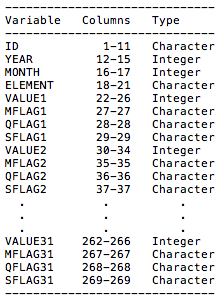

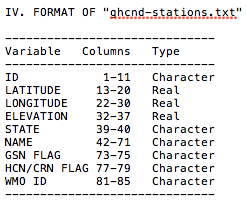

### 2.2.2. Importing Station Metadata

This section sets up the specs for correctly importing the fixed-width data. I have based my work in this section on this very useful GitLab [snippet](https://gitlab.com/snippets/1838910).

In [8]:
# Setting up specs for importing station metadata

data_header_names = [
    "STATION ID",
    "YEAR",
    "MONTH",
    "ELEMENT"
]

data_header_col_specs = [
    (0,  11),
    (11, 15),
    (15, 17),
    (17, 21)
]

data_header_dtypes = {
    "ID": str,
    "YEAR": int,
    "MONTH": int,
    "ELEMENT": str
}

data_col_names = [[
    "VALUE" + str(i + 1),
    "MFLAG" + str(i + 1),
    "QFLAG" + str(i + 1),
    "SFLAG" + str(i + 1)]
    for i in range(31)
]

# Join sub-lists
data_col_names = sum(data_col_names, [])

data_replacement_col_names = [[
    ("VALUE", i + 1),
    ("MFLAG", i + 1),
    ("QFLAG", i + 1),
    ("SFLAG", i + 1)]
    for i in range(31)
]

# Join sub-lists
data_replacement_col_names = sum(data_replacement_col_names, [])

data_replacement_col_names = pd.MultiIndex.from_tuples(
    data_replacement_col_names,
    names=['VAR_TYPE', 'DAY'])

data_col_specs = [[
    (21 + i * 8, 26 + i * 8),
    (26 + i * 8, 27 + i * 8),
    (27 + i * 8, 28 + i * 8),
    (28 + i * 8, 29 + i * 8)]
    for i in range(31)
]

data_col_specs = sum(data_col_specs, [])

data_col_dtypes = [{
    "VALUE" + str(i + 1): int,
    "MFLAG" + str(i + 1): str,
    "QFLAG" + str(i + 1): str,
    "SFLAG" + str(i + 1): str}
    for i in range(31)
]

data_header_dtypes.update({k: v for d in data_col_dtypes for k, v in d.items()})

In [9]:
# Setting up station metadata specs

metadata_col_specs = [
    (0,  12),
    (12, 21),
    (21, 31),
    (31, 38),
    (38, 41),
    (41, 72),
    (72, 76),
    (76, 80),
    (80, 86)
]

metadata_names = [
    "STATION ID",
    "LATITUDE",
    "LONGITUDE",
    "ELEVATION",
    "STATE",
    "NAME",
    "GSN FLAG",
    "HCN/CRN FLAG",
    "WMO ID"
]

metadata_dtype = {
    "ID": str,
    "STATE": str,
    "NAME": str,
    "GSN FLAG": str,
    "HCN/CRN FLAG": str,
    "WMO ID": str
}


Next, let's read in the station metadata, available locally on my machine:

In [10]:
# read in the local .txt file containing the station metadata
df_stations = pd.read_fwf('/Users/richard/Desktop/datasets/GHCNdaily/ghcnd-stations.txt', 
                              metadata_col_specs, names=metadata_names, index_col='STATION ID', dtype=metadata_dtype)

In [11]:
df_stations.describe()

,LATITUDE,LONGITUDE,ELEVATION
count,115084.000000,115084.000000,115084.000000
mean,24.527608,-39.830056,447.750143
std,29.277420,92.080522,667.252749
min,-90.000000,-179.983000,-999.900000
25%,18.420000,-100.759475,80.000000
50%,36.343300,-83.648500,256.000000
75%,42.813075,13.950000,610.000000
max,83.650000,179.320000,5033.000000


In [12]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115084 entries, ACW00011604 to ZI000067991
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   LATITUDE      115084 non-null  float64
 1   LONGITUDE     115084 non-null  float64
 2   ELEVATION     115084 non-null  float64
 3   STATE         71107 non-null   object 
 4   NAME          115084 non-null  object 
 5   GSN FLAG      991 non-null     object 
 6   HCN/CRN FLAG  1451 non-null    object 
 7   WMO ID        8088 non-null    object 
dtypes: float64(3), object(5)
memory usage: 7.9+ MB


In [13]:
df_stations.shape

(115084, 8)

#### Notes on Station Metadata
- Summary statistics indicate same count of values for each numerical values which is a good sign. 
- Other features (GSN Flag, State, etc.) are missing many values, but these are not very important to us.
- Elevation MIN of -999.9 indicates missing values (see readme.txt)

### 2.2.3. Convert Station Data to GeoDataFrame

Since the station metadata dataframe contains valuable geospatial information, let's convert it to a geodataframe so that we can manipulate it using the geopandas package.

In [14]:
# set up geometry specs 
geometry_stations = [Point(xy) for xy in zip(df_stations['LONGITUDE'], df_stations['LATITUDE'])]

In [15]:
# verify
geometry_stations[:5]

In [16]:
# set coordinate reference system
crs_stations = {'init': 'epsg:4326'}

In [17]:
# create geodataframe for station metadata
gdf_stations = gpd.GeoDataFrame(df_stations, crs=crs_stations, geometry=geometry_stations)

In [18]:
# inspect created geodataframe
gdf_stations.head()

,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID,geometry
STATION ID,,,,,,,,,
ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN,POINT (-61.78330 17.11670)
ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN,POINT (-61.78330 17.13330)
AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196,POINT (55.51700 25.33300)
AEM00041194,25.2550,55.3640,10.4,NaN,DUBAI INTL,NaN,NaN,41194,POINT (55.36400 25.25500)
AEM00041217,24.4330,54.6510,26.8,NaN,ABU DHABI INTL,NaN,NaN,41217,POINT (54.65100 24.43300)


#### Note
In order to execute the spatial join in the next section, we will need to change the Coordinate Reference System to EPSG3857. It is recommended to use only geometry with -85 < latitude < 85. As such, we will remove any stations outside of these bounds.

In [19]:
# inspect geometry bounds
gdf_stations.geometry.bounds.minx.min(), gdf_stations.geometry.bounds.miny.min(), gdf_stations.geometry.bounds.maxx.max(), gdf_stations.geometry.bounds.maxy.max()

(-179.983, -90.0, 179.32, 83.65)

In [20]:
# inspect stations with latitude below -85
gdf_stations[gdf_stations.LATITUDE < -85]

,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID,geometry
STATION ID,,,,,,,,,
AYM00089087,-85.2,-87.883,1634.0,NaN,THIEL MTNS AWS,NaN,NaN,89087,POINT (-87.88300 -85.20000)
AYM00089108,-89.0,-1.017,2755.0,NaN,HENRY,NaN,NaN,89108,POINT (-1.01700 -89.00000)
AYM00089799,-89.0,89.667,2935.0,NaN,NICO,NaN,NaN,89799,POINT (89.66700 -89.00000)
AYW00090001,-90.0,0.000,-999.9,NaN,AMUNDSEN-SCOTT,GSN,NaN,89009,POINT (0.00000 -90.00000)


In [21]:
# subset gdf_stations to include only those with compatible latitude (i.e. remove 4 stations)
labels_to_remove = list(gdf_stations[gdf_stations.LATITUDE < -85].index)
gdf_stations = gdf_stations.drop(labels_to_remove, axis=0)

In [22]:
# verify geometry bounds
gdf_stations.geometry.bounds.minx.min(), gdf_stations.geometry.bounds.miny.min(), gdf_stations.geometry.bounds.maxx.max(), gdf_stations.geometry.bounds.maxy.max()

(-179.983, -84.6, 179.32, 83.65)

We have succesfully removed the 4 stations whose latitudes were out of bounds for the EPSG3857 projection. We can now proceed with our analysis.

Let's plot the station locations to get a sense of their geographic spread.

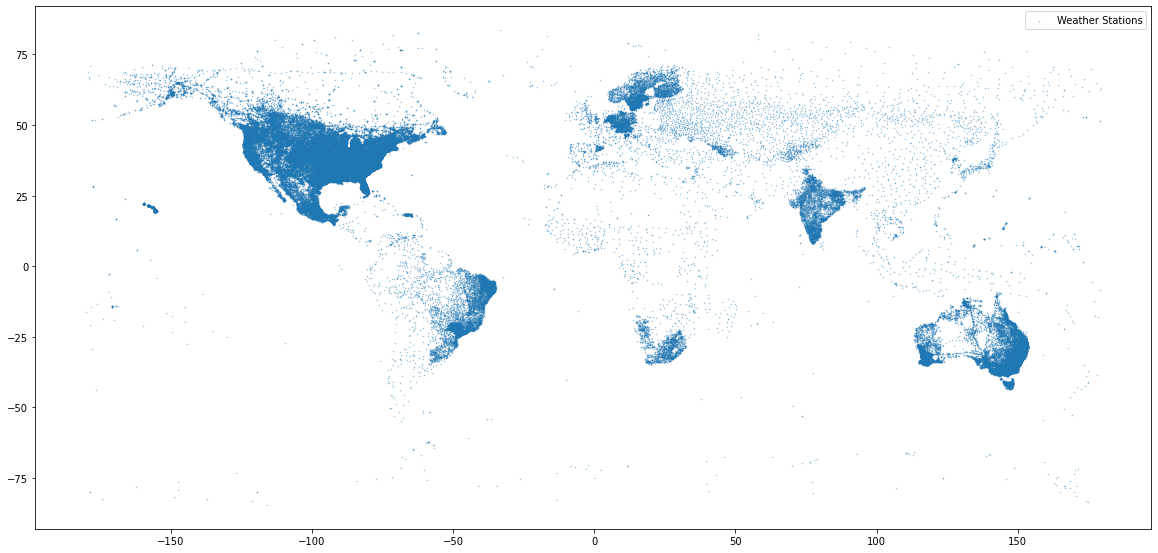

In [23]:
# plot station metadata
fig, ax = plt.subplots(figsize=(20,15))
gdf_stations.plot(ax=ax, alpha=0.5, markersize=0.2, label='Weather Stations')
plt.legend();

In [24]:
# # Exporting Station Metadata to local csv 
# gdf_stations.to_csv('/Users/richard/Desktop/data/interim/station_metadata_gdf_withinboundsepsg3857.csv', na_rep='NaN')

#### Notes on plot
- The plot above highlights clearly that coverage of the GHCN data is not spread evenly across the globe.
- We see particularly high concentrations in:
 - North America
 - East coast of Latin America
 - Northern Europe
 - South Africa
 - India
 - Australia

This is an important first finding to bear in mind as we continue our analysis. How will this coverage of climate data compare to the coverage of the conflict data? Where - and to what extent - will the two overlap in space?

A clarification on the unit measurements is in order. From readme:
- PRCP = Precipitation (tenths of mm)
- SNOW = Snowfall (mm)
- SNWD = Snow depth (mm)
- TMAX = Maximum temperature (tenths of degrees C)
- TMIN = Minimum temperature (tenths of degrees C)

# 3. Wrangling UCDP Conflict Data

Now let's move on to wrangling our UCDP Conflict data into shape. To get a good sense of the quality of our data, we will generate Profile Reports for the datasets. As mentioned in the introduction, the output of the reports has been generated but then excluded from the notebook to enhance compatability with Github. The reports are available as .html files in this repo's 'reports' directory.

In [31]:
# # use ProfileReport
# profile = ProfileReport(df_conflict, title="Pandas Profiling Report", minimal=True)

## 3.1. Notes on Original Profile Report

The conflict dataframe in its original form has:
- 49 variables
- 225385 observations
- 694753 missing cells, constituting 6.3%

### 3.1.1. Missing Values
A quick overview of the missing cells reveals that most of them are in:
- variables detailing information about the source of information (e.g. source_headline, source_office, source_date).
- variables gwnoa and gwnob, which contain the Gleditsch and Ward number of the A or B side of the conflict ifeither is a state.
- adm_2, which contains the name of the second-order administrative region where the conflict took place.

Since we trust the organisation that has compiled this dataset, we will take the credibility of the sources as given and can therefore omit the variables containing the detailed source information.

Variables *gwnoa* and *gwnob* don't provide us much additional information beyond the names contained in variables *side_a* and *side_b*. We will omit these variables as well.

*adm_2* is a potentially important identifier of locality of conflicts, so we will keep it for now, even though it contains almost 23% missing values.

### 3.1.2. Redundant Variables
From the readme pdf included with the dataset, we learn that a number of variables are redundant for our analysis. They contain information referencing older versions of the dataset and are included for administrative purposes. These are: relid, code_status, conflict_dset_id, dyad_dset_id, side_a_dset_id, side_b_dset_id, geom_wkt, priogrid_gid. All of these variables have counterparts in the dataset that contain the updated information and can therefore be ommitted from our analysis.

To summarize, list of variables to omit:
- source_article
- source_headline
- source_date
- source_office
- number_of_sources
- source_original
- relid
- code_status
- conflict_dset_id
- dyad_dset_id
- side_a_dset_id
- side_b_dset_id
- geom_wkt
- priogrid_gid
- gwnoa
- gwnob
- best
- high
- low

### 3.1.3. Important Precision Variables
The dataset includes two important variables that indicate the precision of the location and date of the conflict incidents, respectively.

##### where_prec
contains an integer from 1 to 7 indicating the precision of the coordinates provided.
1. exact location known
2. location known within 25 km.
3. location known at second-order administrative region
4. location known at first-order administrative region
5. location known at large informal region or geographical feature (such as a river or mountain range)
6. only country is known
7. event occurred in international waters or airspace

Detailed information of where_prec included in the Profile Report shows us that the majority of values have a value of 4 or less (~95%). Since we are aiming to include weather stations within a radius of 50km of conflict incidents, this seems a reasonable level of precision to accept.

We will therefore filter the dataset to include only conflict incidents with a where_prec of < 5.

##### date_prec
contains an integer from 1 to 5 indicating the precision of the date provided.
1. exact date is known
2. date is known within 2-6 days
3. date is known within week
4. date is known within 8-30 days
5. date is known within year

Detailed information of date_prec included in the Profile Report shows us that the majority of values have a value of 4 or less (~99%). 83.9% of values even have a date_prec of 1, meaning the exact date is known for the majority of events. Since we are looking at long-term climate trends (climate change) a date_prec of 4 seems a reasonable level of precision to accept.

We will therefore filter the dataset to include only conflict incidents with a date_prec of < 5.


### Next Steps
In conclusion, we will proceed to do the following:
1. Remove redundant variables (listed above)
2. Filter dataframe to include only entries at relevant precision level
3. Convert date columns to datetime objects
4. Save cleaned df as a local csv

## 3.2. Removing Redundant Variables

In [32]:
# removing redundant variables
df_conflict = df_conflict.drop(['source_article', 'source_headline', 'source_date', 'gwnoa', 'gwnob', 'best', 'high', 'low', 'source_office', 'number_of_sources', 'source_original', 'relid', 'code_status', 'conflict_dset_id', 'dyad_dset_id', 'side_a_dset_id', 'side_b_dset_id', 'geom_wkt', 'priogrid_gid'], axis=1)
df_conflict.columns

Index(['id', 'year', 'active_year', 'type_of_violence', 'conflict_new_id',
       'conflict_name', 'dyad_new_id', 'dyad_name', 'side_a_new_id', 'side_a',
       'side_b_new_id', 'side_b', 'where_prec', 'where_coordinates',
       'where_description', 'adm_1', 'adm_2', 'latitude', 'longitude',
       'country', 'country_id', 'region', 'event_clarity', 'date_prec',
       'date_start', 'date_end', 'deaths_a', 'deaths_b', 'deaths_civilians',
       'deaths_unknown'],
      dtype='object')

In [33]:
df_conflict.shape

(225385, 30)

## 3.3. Filter Data by Precision Level

In [34]:
# filter dataframe by where_prec < 5 and date_prec < 5
df_conflict = df_conflict[((df_conflict['where_prec'] < 5) & (df_conflict['date_prec'] < 5))]

In [35]:
df_conflict['date_prec'].value_counts()

1    181060
2     24274
4      5021
3      1522
0         2
Name: date_prec, dtype: int64

In [36]:
df_conflict['where_prec'].value_counts()

1    101885
2     42682
3     37933
4     29379
Name: where_prec, dtype: int64

In [37]:
df_conflict.shape

(211879, 30)

In [38]:
# set index of df to column 'id'
df_conflict.set_index('id', inplace=True)

## 3.4. Convert Date Columns to Datetime Objects

In [39]:
# convert variables date_start and date_end to datetime objects
df_conflict['date_start'] = pd.to_datetime(df_conflict['date_start'])
df_conflict['date_end'] = pd.to_datetime(df_conflict['date_end'])

In [40]:
# verify id and datetime objects
df_conflict

,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,side_a,side_b_new_id,...,country_id,region,event_clarity,date_prec,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown
id,,,,,,,,,,,,,,,,,,,,,
244657,2017,1,1,259,Iraq: Government,524,Government of Iraq - IS,116,Government of Iraq,234,...,700,Asia,1,1,2017-07-31,2017-07-31,0,4,0,2
132140,1989,1,1,333,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,130,Government of Afghanistan,292,...,700,Asia,1,3,1989-01-07,1989-01-13,6,0,0,0
130364,1989,1,1,333,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,130,Government of Afghanistan,292,...,700,Asia,2,2,1989-01-15,1989-01-18,0,0,0,4
130359,1989,1,1,333,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,130,Government of Afghanistan,292,...,700,Asia,1,2,1989-01-23,1989-01-24,0,0,0,600
133883,1989,1,1,333,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,130,Government of Afghanistan,292,...,700,Asia,1,3,1989-01-30,1989-02-05,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326022,2019,0,3,476,Government of Zimbabwe (Rhodesia) - Civilians,943,Government of Zimbabwe (Rhodesia) - Civilians,101,Government of Zimbabwe (Rhodesia),1,...,552,Africa,1,1,2019-10-12,2019-10-12,0,0,1,0
325975,2019,0,3,476,Government of Zimbabwe (Rhodesia) - Civilians,943,Government of Zimbabwe (Rhodesia) - Civilians,101,Government of Zimbabwe (Rhodesia),1,...,552,Africa,1,1,2019-12-26,2019-12-26,0,0,2,0
15525,1989,1,3,562,Renamo - Civilians,1029,Renamo - Civilians,498,Renamo,1,...,552,Africa,1,3,1989-03-18,1989-03-24,0,0,9,0


## 3.5. Export Cleaned Dataframe to Local CSV

In [41]:
# df_conflict.to_csv('/Users/richard/Desktop/data/interim/df_conflict_clean_section3.csv',
#                  index=False)

# 4. Spatial Joins

Before moving on to a Profile Report of the GHCN dataset, it is important to note that the dataset is extremely large and may not all be relevant for our analysis. Based on visual exploration of the documentation it is already clear that a large amount of weather stations are located in geographical areas *other* than the ones in which the conflict incidents registered by the UCDP took place. Because of this, we will now:
- plot the two datasets in order to confirm this, then move on to 
- execute a spatial join to select weather stations that are within 50km of conflict incidents. 

The radius of 50km is selected because it allows us to maintain a sufficient level of spatial detail while also ensuring that areas with high conflict density but weather station sparsity are represented. The radius of 50km corresponds roughly to the intermediary between the 2nd and 3rd level of the *date_prec* variable included in the UCDP conflict data, and explained above in Section 3.1.

## 4.1 Plotting Climate & Conflict Data

In [42]:
# create geodataframe of conflict data
crs_conflict = {'init': 'epsg:4326'}
geometry_conflict = [Point(xy) for xy in zip(df_conflict['longitude'], df_conflict['latitude'])]
gdf_conflict = gpd.GeoDataFrame(df_conflict, crs=crs_conflict, geometry=geometry_conflict)

In [43]:
gdf_conflict.head()

,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,side_a,side_b_new_id,...,region,event_clarity,date_prec,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,geometry
id,,,,,,,,,,,,,,,,,,,,,
244657,2017,1,1,259,Iraq: Government,524,Government of Iraq - IS,116,Government of Iraq,234,...,Asia,1,1,2017-07-31,2017-07-31,0,4,0,2,POINT (69.16280 34.53109)
132140,1989,1,1,333,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,130,Government of Afghanistan,292,...,Asia,1,3,1989-01-07,1989-01-13,6,0,0,0,POINT (70.41667 34.33333)
130364,1989,1,1,333,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,130,Government of Afghanistan,292,...,Asia,2,2,1989-01-15,1989-01-18,0,0,0,4,POINT (68.75000 36.75000)
130359,1989,1,1,333,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,130,Government of Afghanistan,292,...,Asia,1,2,1989-01-23,1989-01-24,0,0,0,600,POINT (69.03889 35.31583)
133883,1989,1,1,333,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,130,Government of Afghanistan,292,...,Asia,1,3,1989-01-30,1989-02-05,0,0,0,2,POINT (69.16280 34.53109)


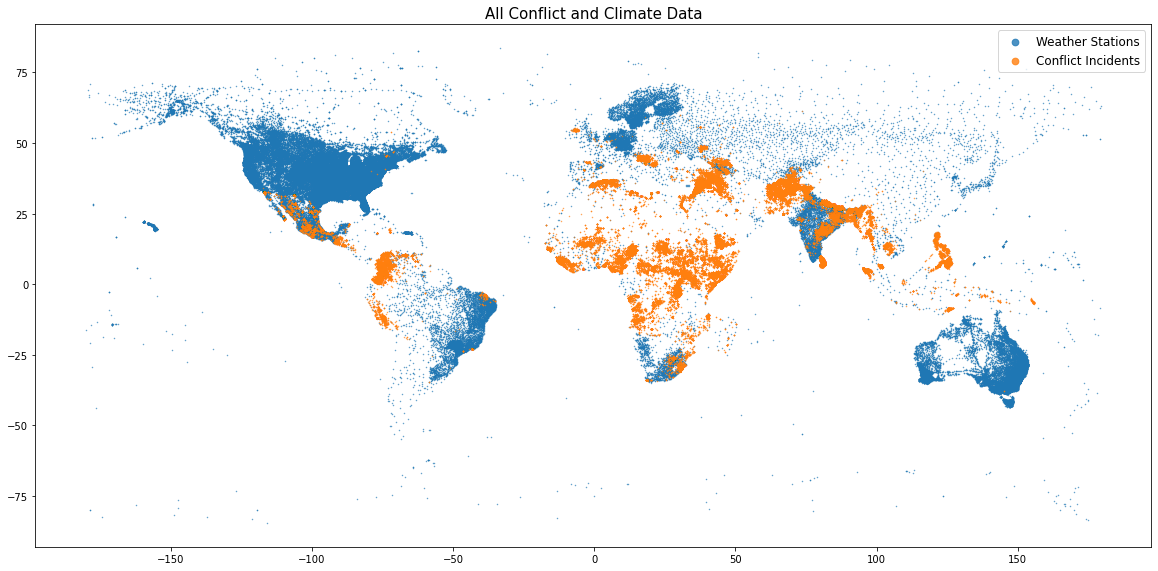

In [45]:
# plot the two geodataframes: station locations and conflict incidents
fig, ax = plt.subplots(figsize=(20,15))
gdf_stations.plot(ax=ax, alpha=0.8, markersize=0.2, label='Weather Stations')
gdf_conflict.plot(ax=ax, alpha=0.8, markersize=0.2, label='Conflict Incidents')
plt.title('All Conflict and Climate Data', fontsize=15)
plt.legend(loc=1, fontsize='large', markerscale=15)

#plt.savefig('/Users/richard/Desktop/springboard_repo/capstones/capstone-two/reports/figures/Globe_allconflicts_allstations.png');

#### Notes
- As expected, the conflicts are mostly *not located* in the areas with the most dense climate measure coverage.

NOTE:
Always plot this subset of the original stations GDF rather than the whole spatial join because single weather stations are plotted multiple times in the spatial join. This plot is cleaner because there are no repetitions of station IDs.

## 4.2 Spatial Join with 50KM Buffer

We will now proceed to execute a spatial join of the two datasets (stations and conflict incidents) to yield:
> **a geodataframe with all weather stations located within 50km of any conflict incident**

This will allow us to significantly reduce the size of our GHCN climate dataset and omit the areas that are not relevant to our analysis (i.e. areas without conflict incidents).

In [89]:
# convert both geodataframes to CRS EPSG3857 = meters (instead of degrees)
gdf_conflict_mtr = gdf_conflict.to_crs(epsg = 3857)
gdf_stations_mtr = gdf_stations.to_crs(epsg = 3857)

In [90]:
# create buffered gdf at 50k
gdf_conflict_buffered50k = gdf_conflict_mtr.copy()
gdf_conflict_buffered50k.geometry = gdf_conflict_mtr.buffer(50000)

In [91]:
# inspect buffered dataframe
gdf_conflict_buffered50k.head()

,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,side_a,side_b_new_id,...,region,event_clarity,date_prec,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,geometry
id,,,,,,,,,,,,,,,,,,,,,
244657,2017,1,1,259,Iraq: Government,524,Government of Iraq - IS,116,Government of Iraq,234,...,Asia,1,1,2017-07-31,2017-07-31,0,4,0,2,"POLYGON ((7749167.233 4100339.871, 7748926.469..."
132140,1989,1,1,333,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,130,Government of Afghanistan,292,...,Asia,1,3,1989-01-07,1989-01-13,6,0,0,0,"POLYGON ((7888747.848 4073648.403, 7888507.084..."
130364,1989,1,1,333,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,130,Government of Afghanistan,292,...,Asia,2,2,1989-01-15,1989-01-18,0,0,0,4,"POLYGON ((7703214.992 4404317.064, 7702974.228..."
130359,1989,1,1,333,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,130,Government of Afghanistan,292,...,Asia,1,2,1989-01-23,1989-01-24,0,0,0,600,"POLYGON ((7735373.968 4206884.851, 7735133.205..."
133883,1989,1,1,333,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,130,Government of Afghanistan,292,...,Asia,1,3,1989-01-30,1989-02-05,0,0,0,2,"POLYGON ((7749167.233 4100339.871, 7748926.469..."


In [92]:
# execute inner spatial join of gdf_stations to buffered gdf_conflict
gdf_sjoin50k = gpd.sjoin(gdf_stations_mtr, gdf_conflict_buffered50k, how='inner', op='within')

### 4.2.1. Inspecting Spatial Join Dataframe

In [93]:
gdf_sjoin50k.head()

,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID,geometry,index_right,...,country_id,region,event_clarity,date_prec,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown
AE000041196,25.333,55.517,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196,POINT (6180124.170 2916701.927),179967,...,696,Middle East,1,1,2010-01-20,2010-01-20,0,1,0,0
AEM00041194,25.255,55.364,10.4,NaN,DUBAI INTL,NaN,NaN,41194,POINT (6163092.288 2907098.278),179967,...,696,Middle East,1,1,2010-01-20,2010-01-20,0,1,0,0
AF000040930,35.317,69.017,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930,POINT (7682937.296 4207044.060),146737,...,700,Asia,1,1,2001-05-17,2001-05-17,0,0,4,0
AF000040930,35.317,69.017,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930,POINT (7682937.296 4207044.060),134532,...,700,Asia,1,2,1997-04-02,1997-04-04,0,0,0,0
AF000040930,35.317,69.017,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930,POINT (7682937.296 4207044.060),134751,...,700,Asia,1,1,1998-03-27,1998-03-27,0,0,3,0


In [94]:
gdf_sjoin50k.columns

Index(['LATITUDE', 'LONGITUDE', 'ELEVATION', 'STATE', 'NAME', 'GSN FLAG',
       'HCN/CRN FLAG', 'WMO ID', 'geometry', 'index_right', 'year',
       'active_year', 'type_of_violence', 'conflict_new_id', 'conflict_name',
       'dyad_new_id', 'dyad_name', 'side_a_new_id', 'side_a', 'side_b_new_id',
       'side_b', 'where_prec', 'where_coordinates', 'where_description',
       'adm_1', 'adm_2', 'latitude', 'longitude', 'country', 'country_id',
       'region', 'event_clarity', 'date_prec', 'date_start', 'date_end',
       'deaths_a', 'deaths_b', 'deaths_civilians', 'deaths_unknown'],
      dtype='object')

In [95]:
gdf_sjoin50k.shape

(455461, 39)

This dataframe now contains:
- 455461 observations, 
- the features of both the stations and the conflict incidents, and
- the geometry points of the weather stations

These are the stations that are located within 50km of any conflict incident and as such **exclude** the weather stations that are not located in areas of conflict.

An important observation: the number of weather stations has almost tripled by executing this spatial join. This is because a single weather station can be in the 50km radius of more than 1 conflict incident. We will have to account for these duplicates later on in our analysis.

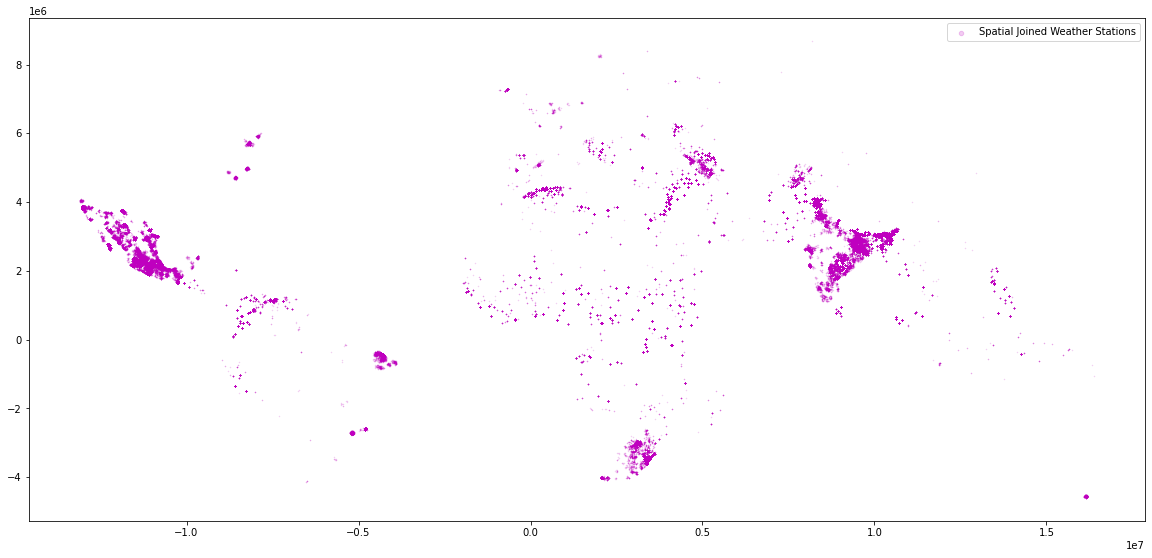

In [96]:
# plot the spatially-joined weather stations
fig, ax = plt.subplots(figsize=(20,15))
gdf_sjoin50k.plot(ax=ax, alpha=0.2, markersize=0.2, color = 'm', label='Spatial Joined Weather Stations')
plt.legend(markerscale=10);

### 4.2.2. Removing superfluous information
This spatially joined dataset now includes all the stations that are found within 50km of all conflict incidents. However, the dataset currently contains a lot of superfluous data. Because many stations will fall within the range of multiple conflict incidents, this dataset contains a large number of repeated observations. As such, it is of practical significance **to reduce the size of this dataframe and retain only what is absolutely necessary**. In this case: the specific details of the conflict incidents are found in the original conflict dataset and do not need to remain in this dataset. 

What we want in this dataset is: 
- a multi-index of Conflict ID, then matched Station IDs; 
- the corresponding station name;
- each station's latitude and longitude as a geopandas geometry point;

In [97]:
# adjust spatial join gdf to retain only station IDs, station Names, station Point, and Conflict ID
gdf_sjoin50k_clean = gdf_sjoin50k[['NAME', 'geometry', 'index_right']]
gdf_sjoin50k_clean.reset_index(inplace=True)
gdf_sjoin50k_clean = gdf_sjoin50k_clean.rename(columns={"NAME": "station_name", 
                             "geometry": "geometry",
                             "index_right": "conflict_ID",
                             "index": "station_ID"
                            })

In [98]:
# inspect stripped dataframe
gdf_sjoin50k_clean.head()

,station_ID,station_name,geometry,conflict_ID
0,AE000041196,SHARJAH INTER. AIRP,POINT (6180124.170 2916701.927),179967
1,AEM00041194,DUBAI INTL,POINT (6163092.288 2907098.278),179967
2,AF000040930,NORTH-SALANG,POINT (7682937.296 4207044.060),146737
3,AF000040930,NORTH-SALANG,POINT (7682937.296 4207044.060),134532
4,AF000040930,NORTH-SALANG,POINT (7682937.296 4207044.060),134751


In [99]:
# create a MultiIndex of 1: conflict_ID and 2: station_ID
gdf_sjoin50k_clean.set_index(['conflict_ID', 'station_ID'], inplace=True)
gdf_sjoin50k_clean.sort_index(inplace=True)

In [100]:
# inspect dataframe with new MultiIndex
gdf_sjoin50k_clean.head(20)

station_name  \
conflict_ID station_ID                              
1489        AGE00147716       NEMOURS (GHAZAOUET)   
            AGM00060522                   MAGHNIA   
            AGM00060531                    ZENATA   
            MOE00147755                     OUJDA   
1490        AGM00060452                     ARZEW   
            AGM00060461                 ORAN-PORT   
            AGM00060490                  ES SENIA   
1491        AGM00060506          MASCARA-MATEMORE   
            AGM00060507                    GHRISS   
1492        AGM00060437                     MEDEA   
1496        AG000060390        ALGER-DAR EL BEIDA   
            AGE00147708                TIZI OUZOU   
            AGM00060387                    DELLYS   
1497        AG000060390        ALGER-DAR EL BEIDA   
            AGE00147705  ALGIERS-VILLE/UNIVERSITE   
            AGE00147706         ALGIERS-BOUZAREAH   
            AGE00147707        ALGIERS-CAP CAXINE   
            AGM00060369                ALGER-PORT   
1499        AGM00060506          MASCARA-MATEMORE   
            AGM00060507                    GHRISS   

                                                geometry  
conflict_ID station_ID                                    
1489        AGE00147716  POINT (-205941.058 4177479.062)  
            AGM00060522  POINT (-197035.499 4139446.688)  
            AGM00060531  POINT (-161413.262 4166191.616)  
            MOE00147755  POINT (-214846.617 4134024.068)  
1490        AGM00060452   POINT (-29722.304 4275469.983)  
            AGM00060461   POINT (-72357.669 4259419.966)  
            AGM00060490   POINT (-69129.404 4249006.930)  
1491        AGM00060506    POINT (33395.847 4245720.660)  
            AGM00060507    POINT (16363.965 4192183.562)  
1492        AGM00060437   POINT (304236.168 4339631.933)  
1496        AG000060390   POINT (361788.345 4399691.644)  
            AGE00147708   POINT (450843.938 4400149.930)  
            AGM00060387   POINT (439711.989 4427543.964)  
1497        AG000060390   POINT (361788.345 4399691.644)  
            AGE00147705   POINT (341750.837 4408485.828)  
            AGE00147706   POINT (337298.057 4411265.910)  
            AGE00147707   POINT (338411.252 4411265.910)  
            AGM00060369   POINT (345090.421 4406679.163)  
1499        AGM00060506    POINT (33395.847 4245720.660)  
            AGM00060507    POINT (16363.965 4192183.562)

In [101]:
# # export spatial join gdf to local .csv 
# gdf_sjoin50k_clean.to_csv('/Users/richard/Desktop/data/interim/sjoin_50kbuffer_clean_MultiIndex.csv')

#### Note on Data Collection
As mentioned earlier, the GHCN climate data is too large to read onto this machine in its entirety (>40GB). As such, we will only extract the files pertaining to the stations located within the 50km buffer we have defined. These are **the unique station_ID values in the spatial-join dataframe above**. 

Below we extract these unique values as a list and save it as a local .csv file. This .csv file is used to extract the corresponding .dly files from the .tar archive.

**IMPORTANT: the data extraction is done in a separate notebook: 01_Data_Collection, available in this repo.**

In [102]:
# create list of station IDs within 50k buffer of conflicts
list_stations_buf50k = gdf_sjoin50k.index.unique()

In [103]:
# convert to df, then export this list to local .csv
df_stations50k = pd.DataFrame(list_stations_buf50k)
# df_stations50k.to_csv('/Users/data_science/Desktop/springboard_repo/capstones/capstone-two/data/interim/stationIDs_50k.csv')

### 4.2.2. Data collection

We use the created csv with station IDs to extract the corresponding .dly's into .csv's and store those locally. This is done in the Notebook '01 Data Collection'.

## 4.3 Import Spatial Join 50km .csv Files

### Note
The .csv files which are imported into the notebook below were extracted from the original tar archive using a separate notebook ('01 Data Collection').


In [ ]:
%%time
# create df with PRCRP, TMAX, TMIN, TAVG, SNOW, SNWD of all 10000+ stations within 50km of conflict incidents
# this takes about 10min to run

path_to_50k = '/Users/data_science/Desktop/springboard_repo/capstones/capstone-two/data/raw/extracted_stations_buffer50km/*'
df_stations_50k = pd.concat(
    [pd.read_csv(f, 
                 parse_dates=[0], 
                 usecols=lambda x: x in ['Unnamed: 0', 'STATION ID', 'PRCP', 'TMAX', 'TMIN', 'TAVG', 'SNOW', 'SNWD'])
                    for f in glob.glob(path_to_50k)], ignore_index = True)


In [ ]:
# import df_stations_50k from local csv 
df_stations_50k = pd.read_csv()

In [ ]:
df_stations_50k.info()

In [ ]:
# rename the first column = "DATE"
df_stations_50k.rename(columns={'Unnamed: 0': 'DATE'}, inplace=True)

In [ ]:
# create MultiIndex of date and station_ID
df_stations_50k.set_index(['DATE', 'STATION ID'], inplace=True)
df_stations_50k.sort_index(inplace=True)

In [ ]:
df_stations_50k.head()

In [ ]:
# # export df to local csv
# df_stations_50k.to_csv('/Users/data_science/Desktop/springboard_repo/capstones/capstone-two/data/interim/df_weather_50k.csv')

# 5. Wrangling the GHCN Weather Data

The ProfileReports for the GHCN data were generated in a separate Notebook ("000_Profile_Report_Weather_50km") and are imported here as html files. The dataset was too large for to be processed in a single report so separate reports were generated for each feature: PRCP, TAVG, TMIN, TMAX, SNOW, and SNWD.

**NOTE: All profile reports reviewed below can be found in the 'reports' directory that is part of this repo.**

## 5.1. Quality-Check per Feature
This section provides the conclusions of the quality-check of each feature of the GHCN dataset. Conclusions are drawns and next steps outlined. Section 5.2 proceeds to manipulate the dataset based on the conclusions from this section.

### 5.1.1. PRCP - Precipitation Levels

- Reminder: PRCP is measured in tenths of mm

DATE:
- There are 135.671.294 observations, spanning from  January 1833 until October 2020
- The DATE histogram shows us that recordings of PRCP increase dramatically after 1906.
- The highest density of PRCP recordings lies between ~1950 and ~1990.

PRCP:
- There are close to 6 million missing PRCP values, ~4.5%
- Close to 75% of the PRCP values are 0 (which simply means no rain)
- The maximum value of PRCP is 25397 = ~2.5m of rain, which seems like it's an outlier. 55 observations have exactly this value. A number of other single observations also have values of ~2000mm.
- Quick research confirms that World Record of rainfall in a single day (24h) is 1825mm: see [url](http://www.bom.gov.au/water/designRainfalls/rainfallEvents/worldRecRainfall.shtml)
- The minimum value of PRCP is -6660, which seems to indicate either a missing value or a registration error as negative precipitation is not physically possible. This value occurs a total of 5 times. The negative value of -8 occurs twice.

### To Do
- Convert any values above 17000 to NaN. ~60 values in total.
- Convert negative values to NaN. Since there are only 7 in total, this won't practically affect the total missingness of this variable.



### 5.1.2. TMAX - Maximum Temperature

- Reminder: TMAX is measured in tenths of degrees Centigrade

DATE:
- There are 135.671.294 observations, spanning from  January 1833 until October 2020.
- This is the same exact number of observations as PRCP.
- Just like PRCP, the DATE histogram here shows us that recordings of TMAX increase dramatically after 1906.
- Just like PRCP, the highest density of TMAX recordings lies between ~1950 and ~1990.

TMAX:
- There are >55% missing values for TMAX
- There are ~50 values below the World Record for lowest temperature (-89C = 890 in tenths of C). Minimum value is -5733 = -573C. These must be registration errors.
- There are also ~50 values far above the World Record for highest temperature (54C = 540 in tenth of C). These must be registration errors.

### To Do
- Convert extreme values (< 530 or > -800) to NaN.
- Keep the variable for now, but be aware of high missingness.
- Perhaps find a way to filter out stations that DO have reliable measurement for this variable.

### 5.1.3. TMIN - Minimum Temperature

- TMIN is recorded in tenths of degrees C

- There are  >55% missing values for TMIN (same % as TMAX)
- There are missing values indicated by 9990
- There are outliers / registration errors that exceed the World Record for hottest T = 540
- There are outliers / registration errors that exceed the World Record for coldest T = 890

### To Do
- Convert extreme values (>530 or < 800) to NaN.
- Keep the variable for now, but be aware of high missingness.
- Perhaps find a way to filter out stations that DO have reliable measurement for this variable.

### 5.1.4. TAVG - Average Temperature

- TAVG is recorded in tenths of degrees C

- There are  >90% missing values for TAVG
- However, in analysis of single stations I have seen that TAVG can for some stations provide the most reliable measurements.


### To Do
- Convert extreme values (>530 or < 800) to NaN.
- Keep the variable for now, but be aware of high missingness.
- Perhaps find a way to filter out stations that DO have reliable measurement for this variable.

### 5.1.5. SNOW - Snowfall

- SNOW is snowfall, measured in mm

- High degree of missingness (>95%) but considering the fact that many of the conflict areas are in warmer climates, this is not surprising.
- Maximum value of 25397 occurs 55 times. This must be a registration error, we will treat it as NaN.



### 5.1.6. SNWD - Snow Depth

- SNWD is snow depth, measured in mm.

- High degree of missingness (>95%) but considering the fact that many of the conflict areas are in warmer climates, this is not surprising.
- Minimum values below 0 must be registration errors, we will treat those as NaN (total count = 106)
- Maximum values of >55000 = ~5.5m; plausible snowdepth for high mountain ranges, keep as is.


## 5.2 GHCN Data Cleaning
Based on the findings in the previous section, this section will:

1. Convert extreme outliers to NaN
2. Impute TAVG from TMAX and TMIN where possible
3. Evaluate whether to keep SNOW and SNWD as features
4. Subset the climate data for years relevant to our analysis 

### 5.2.1 Converting extreme outliers to NaN

**NOTE TO SELF** MacBook Air can't seem to open this file, keeps crashing. run this on MacBook Pro instead, then upload

In [ ]:
# import csv containing weather data from stations within 50km of conflict incidents
df_weather = pd.read_csv('/Users/richard/Desktop/data/interim/df_weather_50k.csv', index_col=0, parse_dates=[0])

In [ ]:
df_weather.head()

In [5]:
# copy df in order to clean out outliers
df_weather_clean = df_weather.copy()

In [16]:
# PRCP
# any values above 17000 to NaN
df_weather_clean.loc[df_weather_clean['PRCP'] > 17000] = np.nan

# any values below 0 to NaN
df_weather_clean.loc[df_weather_clean['PRCP'] < 0] = np.nan

In [23]:
# TMAX
# Convert extreme values (> 530 or < -800) to NaN.
df_weather_clean.loc[df_weather_clean['TMAX'] > 530] = np.nan
df_weather_clean.loc[df_weather_clean['TMAX'] < -800] = np.nan

In [26]:
# TMIN
# Convert extreme values (> 530 or < -800) to NaN.
df_weather_clean.loc[df_weather_clean['TMIN'] > 530] = np.nan
df_weather_clean.loc[df_weather_clean['TMIN'] < -800] = np.nan

In [28]:
# TAVG
# Convert extreme values (> 530 or < -800) to NaN.
df_weather_clean.loc[df_weather_clean['TAVG'] > 530] = np.nan
df_weather_clean.loc[df_weather_clean['TAVG'] < -800] = np.nan

In [32]:
# SNOW
# Convert extreme values (25397) to NaN.
df_weather_clean.loc[df_weather_clean['SNOW'] == 25397] = np.nan

In [34]:
# SNWD
# convert negative values to NaN.
df_weather_clean.loc[df_weather_clean['SNWD'] < 0] = np.nan

In [ ]:
# # export cleaned df to local csv
# df_weather_clean.to_csv('/Users/richard/Desktop/data/interim/df_weather_50k_clean_old.csv'

### 5.2.2. Imputing TAVG 
TMAX and TMIN have much fewer missing values than TAVG. Fortunately, we can confidently impute TAVG from TMAX and TMIN (TAVG = (TMAX+TMIN) / 2).

This section does exactly that for the rows for which TAVG is NaN and both TMAX and TMIN are available.

Let's begin by checking how many stations that are missing TAVG values DO have TMIN and TMAX values

In [2]:
# importing local csv with cleaned df
df_weather = pd.read_csv('/Users/richard/Desktop/data/interim/df_weather_50k_clean.csv', index_col=[0,1], parse_dates=[0])

In [3]:
df_weather.head()

,,PRCP,TAVG,TMAX,TMIN,SNWD,SNOW
DATE,STATION ID,,,,,,
1833-01-02,BE000006447,NaN,NaN,-14.0,-48.0,NaN,NaN
1833-01-03,BE000006447,NaN,NaN,-31.0,-68.0,NaN,NaN
1833-01-04,BE000006447,NaN,NaN,-39.0,-68.0,NaN,NaN
1833-01-05,BE000006447,NaN,NaN,-44.0,-90.0,NaN,NaN
1833-01-06,BE000006447,NaN,NaN,14.0,-85.0,NaN,NaN


In [5]:
# index dataframe to return all entries for which TAVG is NaN
df_weather[df_weather.TAVG.isnull()]

PRCP  TAVG   TMAX   TMIN  SNWD  SNOW
DATE       STATION ID                                       
1833-01-02 BE000006447   NaN   NaN  -14.0  -48.0   NaN   NaN
1833-01-03 BE000006447   NaN   NaN  -31.0  -68.0   NaN   NaN
1833-01-04 BE000006447   NaN   NaN  -39.0  -68.0   NaN   NaN
1833-01-05 BE000006447   NaN   NaN  -44.0  -90.0   NaN   NaN
1833-01-06 BE000006447   NaN   NaN   14.0  -85.0   NaN   NaN
...                      ...   ...    ...    ...   ...   ...
2020-10-20 USC00417622   0.0   NaN  350.0  233.0   NaN   NaN
           USC00418059   NaN   NaN    NaN    NaN   NaN   NaN
           USC00419588   0.0   NaN  339.0  239.0   NaN   NaN
           USC00445204   0.0   NaN  211.0  111.0   NaN   NaN
           USC00448737   0.0   NaN  200.0  128.0   0.0   0.0

[122837288 rows x 6 columns]

In [6]:
df_weather.shape

(135671294, 6)

There are close to 122 million entries (read: days at stations) for which TAVG is missing. As noted above, this is more than 90% of the in total 135 million entries in this dataset.

For stations that are missing TAVG but have TMAX and TMIN, let's now impute TAVG = (TMIN + TMAX) / 2

In [7]:
# use pd.fillna() to impute missing TAVG values using TMIN and TMAX
df_weather['TAVG'] = df_weather['TAVG'].fillna((df_weather['TMIN'] + df_weather['TMAX']) / 2)

In [8]:
# verify by checking single entry for which TAVG was previously NaN
df_weather.loc['1833-01-02', 'BE000006447']

/opt/miniconda3/envs/sklearn/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  


,,PRCP,TAVG,TMAX,TMIN,SNWD,SNOW
DATE,STATION ID,,,,,,
1833-01-02,BE000006447,NaN,-31.0,-14.0,-48.0,NaN,NaN


This works as expected.

Let's now check the NaN count for TAVG

In [9]:
# check new NaN count for TAVG
df_weather.TAVG.isnull().sum()

73306365

In [10]:
df_weather.TMIN.isnull().sum(), df_weather.TMAX.isnull().sum()

(76441311, 76320966)

This is a significant improvement, almost half of the missing TAVG values have been imputed.

As a result, TAVG now has the least missing values of all three Temperature measures and will be our temperature measure of choice moving forward.

### 5.2.3 Check Zeroes in SNOW and SNWD

As noted above in Section 5.1, both SNOW and SNWD have a very high number of NaN values. In this section, we are going to check the number of 0 values in those two features in order to evaluate whether perhaps the NaN's can be justifiably imputed as 0.

In [13]:
# check unique values of SNOW
df_weather.SNOW.value_counts()

0.0      5736488
25.0       21693
10.0       17042
13.0       15833
51.0       14561
          ...   
550.0          1
299.0          1
549.0          1
354.0          1
301.0          1
Name: SNOW, Length: 513, dtype: int64

In [14]:
# check NaN count of SNOW
df_weather.SNOW.isnull().sum()

129546332

In [15]:
# check unique values of SNWD
df_weather.SNWD.value_counts()

0.0       5431460
10.0        41766
20.0        38656
51.0        28608
30.0        27620
           ...   
2565.0          1
401.0           1
386.0           1
146.0           1
2779.0          1
Name: SNWD, Length: 679, dtype: int64

In [16]:
# check NaN count of SNWD
df_weather.SNWD.isnull().sum()

129464790

There are a substantial number of zeroes in both SNOW and SNWD. This means we cannot assume that the NaN values for SNOW and SNWD are meant to be zero and we simply have no means of knowing what the values might be. This leaves us with >95% missing values for these two variables. 

As such, we will **disregard these variables and exclude them from our analysis.**

In [28]:
# drop SNOW and SNWD
df_weather.drop(['SNOW', 'SNWD'], axis=1, inplace=True)
df_weather.head()

,,PRCP,TAVG,TMAX,TMIN
DATE,STATION ID,,,,
1833-01-02,BE000006447,NaN,-31.0,-14.0,-48.0
1833-01-03,BE000006447,NaN,-49.5,-31.0,-68.0
1833-01-04,BE000006447,NaN,-53.5,-39.0,-68.0
1833-01-05,BE000006447,NaN,-67.0,-44.0,-90.0
1833-01-06,BE000006447,NaN,-35.5,14.0,-85.0


### 5.2.4 Limiting years included

We saw above in Section 5.1 that the amount of climate data increases dramatically after 1906. We also learned in Section 3.1 that the conflict data spans from 1989 until 2020. 

For this reason, our analysis will most likely concern itself with the years after 1989. But just to give ourselves some leeway and material for comparison, let's maintain everything from 1920 onwards, thus giving us a century of climate data. We will exclude all climate data before this date.

In [29]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 135566584 entries, (Timestamp('1833-01-02 00:00:00'), 'BE000006447') to (Timestamp('2020-10-20 00:00:00'), 'USR0000TLRG')
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   PRCP    float64
 1   TAVG    float64
 2   TMAX    float64
 3   TMIN    float64
dtypes: float64(4)
memory usage: 4.8+ GB


In [30]:
df_weather_1920 = df_weather.loc['1920-01-01':'2020-10-01']

In [31]:
df_weather.shape[0] - df_weather_1920.shape[0] 

11385816

In [32]:
df_weather_1920.shape

(124180768, 4)

Removing all data before 1920 and after September 2020 removes >11mln entries from the weather data, leaving us with a dataframe with >124mln observations and 4 features.

In [33]:
df_weather_1920.head()

PRCP   TAVG   TMAX   TMIN
DATE       STATION ID                             
1920-01-01 AGE00147704   90.0  140.0  170.0  110.0
           AGE00147705  102.0  155.0  190.0  120.0
           AGE00147706   45.0  130.0  160.0  100.0
           AGE00147710   61.0  130.0  170.0   90.0
           AGE00147711  150.0    NaN    NaN    NaN

In [34]:
# %%time
# # export cleaned df after 1920 to local csv
# df_weather_1920.to_csv('/Users/data_science/Desktop/springboard_repo/capstones/capstone-two/data/interim/df_weather_50k_clean_1920onwards.csv')

CPU times: user 1h 53min 15s, sys: 54.2 s, total: 1h 54min 9s
Wall time: 1h 55min 14s


# 6. Summary & Conclusions

In this notebook we have:

1. **Cleaned the UCDP conflict data (Section 3) by:**  

 1. omitting a large number of variables (19) that were not relevant to our analysis. 
 
 2. omitting observations that did not meet our standards for data precision. 
 
 3. exporting the cleaned dataset to local csv 'df_conflict_clean.csv'


2. **Executed a spatial join of climate data to buffered conflict data (Section 4)**
- This was done to obtain only the weather stations located in our areas of interest (conflict)
- The data extraction of .dly files into local .csv's is executed in Notebook 01 Data Collection


3. **Cleaned the GHCN climate data (Section 5) by:**
 1. omitting variables SNOW (snowfall) and SNWD (snow depth) because of high number of NaN values
 2. converting extreme outliers (identified based on additional research) to NaN
 3. limiting data to 1920-2020
 4. exporting the cleaned dataset to local csv 'df_weather_50k_clean.csv'

## 6.1 Summary of UCDP Conflict Data

### 6.1.1. Overview

This section presents the analysis of the Profile Report of the cleaned dataset.

**NOTE:** The profile report of the cleaned dataset can be found in the 'reports' section of this repo.

After removing the redundant variables and filtering for the observations with acceptable location and date precision, we now have a dataframe containing:
- 30 variables
- 211879 observations
- 47067 missing cells ~ 0.7% of dataset; most of which (>41000) are in adm_2 as previously noted.

### 6.1.2. Key Variables for Our Analysis & Points of Concern

##### id
This column contains only unique values, meaning each conflict incident indeed has a unique identifier.

##### years
This column contains integers ranging from 1989 to 2020; an interval of ~30 years.
**This is less than expected and might be an issue.** When downloading the dataset I was under the impression that it stretched from 1946 onwards. I will have to look into this further. A potential issue here might be that a phenomenon like 'climate change' needs to be studied at longer intervals than 30 years.

##### type_of_violence
This is a categorical variable containing 1) for state-based conflicts (74%), 2) for non-state based conflicts (15.8%), and 3) for one-sided conflicts (10.2%). This variable may well be of use in our analysis in order to evaluate trends for different conflict types.

##### conflict_id
There are 1207 unique values in this column, with 2 conflicts (#299 and #333) claiming very high percentages, 20.9% and 13.8% respectively. All other conflict id's account for less than 3% of conflict incidents each. This variable will help us group our conflict incidents by specific conflict. 

##### conflict_name
There are 1206 unique values in this column, meaning **1 conflict_id does not have a corresponding name. Something to look into.**

##### adm_1
This column contains the name of the first-order administrative region in which the conflict incident took place. The column contains 1485 distinct values and only 0.9% are missing. **This may therefore be a good variable to group our conflicts by larger geographical regions.**

##### adm_2
This column contains the name of the second-order administrative region. The column contains 6917 unique values but **41805 missing (~20%)**. While this variable would give us a more fine-grained geographical scale to group our conflict incidents by, the fact that such a large portion of incidents are missing adm_2 values is a trade-off worth considering further at a later stage.

##### latitude & longitude
No missing values for either of these columns. This is great news.

##### country 
No missing values for this column.

##### region
No missing values for this column. Region is either: Middle East, Asia, Africa, America, Europe

##### deaths: side_a, side_b, civilians, unknown
No missing values for this column.
All four variables do **include significant outliers which will have to be investigated further.**
deaths_a: mean = 1.73, max = 10000
deaths_b: mean = 2.29, max = 5000
deaths_civilians: mean = 4.19, max = 40000
deaths_unknown: mean = 1.35, max = 3000

##### date start / end
No missing values for this column. Columns can be converted to datetime object without issues.

## 6.2 Summary of GHCN Climate Data

### 6.2.1. Time Frames
- All variables in the spatially joined GHCN climate dataset have equal number of observations, ranging from January 1833 until October 2020. 
- All variables exhibit a dramatic increase of measurements after 1906
- For all variables, the highest density of recordings lies between ~1950 and ~1990

### 6.2.2. Key Variables for Our Analysis
- PRCP is the most complete variable with <5% missing values.
- TMIN and TMAX are next with ~55% missing values.
- TAVG, SNOW, and SNWD all have ~95% missing values.
- all variables have some extreme outliers which will be treated as registration errors and converted to NaN.



## 6.3 Target Variable
The target variable of our analysis will be **conflict severity**.
We will define this variable based on 1) the number of deaths and 2) the duration of the conflict.

The number of deaths will be calculated from the existing variables: *deaths_a, deaths_b, deaths_civilian* and *deaths_unknown*.

The conflict duration can be calculated from the *date_start* of the first conflict incident of a particular conflict ID and the *date_end* of the last conflict incident pertaining to that same conflict ID.

These variables will be combined into a measurement of conflict severity. We will postpone exact definition of this measure until a later stage of the analysis, after more in-depth exploratory data analysis has been conducted.

## 6.4 Explanatory Variables

We will maintain all variables of the spatially-joined GHCN dataset for the moment and evaluate relevance of specific features on a case-by-case basis as we look at specific conflict regions.